In [1339]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.base import TransformerMixin # from Mahdi

import regex as re

random_state = 11

In [1223]:
master = pd.read_csv('~/downloads/new_beds.csv')

In [1224]:
master = master.drop(columns = 'Unnamed: 0')

In [1225]:
area = pd.read_csv('~/downloads/area_ready.csv')
area.head()

,Unnamed: 0,county,total_area,land_area,water_area
0,0,autauga county,1513895194,1539602155,2.570696e+07
1,1,baldwin county,2984648805,4117625664,1.132977e+09
2,2,barbour county,2241636927,2292160140,5.052321e+07
3,3,bibb county,1602558222,1612159622,9.601400e+06
4,4,blount county,1655136409,1670127873,1.499146e+07


In [1226]:
area = area.drop(columns = 'Unnamed: 0')

In [1227]:
area.head()

,county,total_area,land_area,water_area
0,autauga county,1513895194,1539602155,2.570696e+07
1,baldwin county,2984648805,4117625664,1.132977e+09
2,barbour county,2241636927,2292160140,5.052321e+07
3,bibb county,1602558222,1612159622,9.601400e+06
4,blount county,1655136409,1670127873,1.499146e+07


In [1228]:
master.head()

,county_x,state,id,population,estimate!!race!!total population!!one race,estimate!!race!!total population!!two or more races,estimate!!race!!total population!!one race.1,estimate!!race!!total population!!one race!!white,estimate!!race!!total population!!one race!!black or african american,estimate!!race!!total population!!one race!!american indian and alaska native,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,autauga county,AL,1001,55200,54170,1030,54170,42437,10565,159,...,0.0,0.0,0.0,0.0,1,1001,85.0,0.001214,0.001540,1.268657
1,baldwin county,AL,1003,208107,204535,3572,204535,179526,19764,1522,...,0.0,0.0,0.0,0.0,1,1003,386.0,0.000999,0.001855,1.855769
2,barbour county,AL,1005,25782,25429,353,25429,12216,12266,72,...,0.0,0.0,0.0,0.0,1,1005,74.0,0.002056,0.002870,1.396226
3,bibb county,AL,1007,22527,22340,187,22340,17268,5018,8,...,0.0,0.0,0.0,0.0,1,1007,35.0,0.001953,0.001554,0.795455
4,blount county,AL,1009,57645,56710,935,56710,55054,862,141,...,0.0,0.0,0.0,0.0,1,1009,25.0,0.000763,0.000434,0.568182


In [1229]:
master = pd.merge(area, master, how = 'left', on=area.index)

In [1230]:
master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.0,0.0,0.0,0.0,1,1001,85.0,0.001214,0.001540,1.268657
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.0,0.0,0.0,0.0,1,1003,386.0,0.000999,0.001855,1.855769
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.0,0.0,0.0,0.0,1,1005,74.0,0.002056,0.002870,1.396226
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.0,0.0,0.0,0.0,1,1007,35.0,0.001953,0.001554,0.795455
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.0,0.0,0.0,0.0,1,1009,25.0,0.000763,0.000434,0.568182


In [1231]:
master.loc[master['water_area'].isnull()]

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
889,889,greeley county,2016057907,2016057907,NaN,greeley county,KS,20071,1200,1179,...,0.0,0.0,0.0,0.0,20,20071,18.0,0.0,0.015,inf


Since total area for Greeley County equals land area, I'm going to impute 0 for water area.

In [1232]:
master['water_area'].replace({None: 0}, inplace = True)

In [1233]:
master['pop_density'] = master['population'] / master['total_area']

In [1234]:
master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case,pop_density
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.0,0.0,0.0,1,1001,85.0,0.001214,0.001540,1.268657,0.000036
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.0,0.0,0.0,1,1003,386.0,0.000999,0.001855,1.855769,0.000070
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.0,0.0,0.0,1,1005,74.0,0.002056,0.002870,1.396226,0.000012
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.0,0.0,0.0,1,1007,35.0,0.001953,0.001554,0.795455,0.000014
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.0,0.0,0.0,1,1009,25.0,0.000763,0.000434,0.568182,0.000035


In [1235]:
cens = master[master.columns[8:96]]

In [1236]:
cens.shape

(3108, 88)

In [1237]:
cens[cens.columns[3]]/ cens['population']

0       0.981341
1       0.982836
2       0.986308
3       0.991699
4       0.983780
          ...   
3103    0.979804
3104    0.992020
3105    0.965161
3106    0.958420
3107    0.979718
Length: 3108, dtype: float64

In [1238]:
ratios = []
for num in range(88):
    ratio = cens[cens.columns[num]]/ cens['population']
    ratios.append(ratio)
    

In [1239]:
ratio_df = pd.DataFrame(ratios).T

In [1240]:
ratio_df.columns =  cens.columns

In [1241]:
ratio_df.columns = ratio_df.columns + ' ratio'

In [1242]:
ratio_df

,population ratio,estimate!!race!!total population!!one race ratio,estimate!!race!!total population!!two or more races ratio,estimate!!race!!total population!!one race.1 ratio,estimate!!race!!total population!!one race!!white ratio,estimate!!race!!total population!!one race!!black or african american ratio,estimate!!race!!total population!!one race!!american indian and alaska native ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!cherokee tribal grouping ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!chippewa tribal grouping ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!navajo tribal grouping ratio,...,estimate!!sex and age!!total population!!21 years and over ratio,estimate!!sex and age!!total population!!62 years and over ratio,estimate!!sex and age!!total population!!65 years and over ratio,estimate!!sex and age!!total population!!18 years and over.1 ratio,estimate!!sex and age!!total population!!18 years and over!!male ratio,estimate!!sex and age!!total population!!18 years and over!!female ratio,estimate!!sex and age!!total population!!18 years and over!!sex ratio (males per 100 females) ratio,estimate!!sex and age!!total population!!65 years and over.1 ratio,estimate!!sex and age!!total population!!65 years and over!!male ratio,estimate!!sex and age!!total population!!65 years and over!!female ratio
0,1.0,0.981341,0.018659,0.981341,0.768786,0.191395,0.002880,0.001486,0.0,0.000797,...,0.717645,0.170344,0.145833,0.757808,0.363297,0.394511,0.001668,0.145833,0.063188,0.082645
1,1.0,0.982836,0.017164,0.982836,0.862662,0.094970,0.007314,0.001369,0.0,0.000336,...,0.747221,0.239353,0.195404,0.780512,0.375307,0.405205,0.000445,0.195404,0.090675,0.104730
2,1.0,0.986308,0.013692,0.986308,0.473819,0.475758,0.002793,0.001008,0.0,0.000349,...,0.752230,0.219455,0.179738,0.789155,0.423668,0.365488,0.004495,0.179738,0.077729,0.102009
3,1.0,0.991699,0.008301,0.991699,0.766547,0.222755,0.000355,0.000000,0.0,0.000000,...,0.748613,0.191903,0.162516,0.793182,0.425179,0.368003,0.005127,0.162516,0.072491,0.090025
4,1.0,0.983780,0.016220,0.983780,0.955052,0.014954,0.002446,0.000347,0.0,0.000000,...,0.732622,0.215110,0.177518,0.766363,0.374621,0.391743,0.001658,0.177518,0.078758,0.098760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,1.0,0.979804,0.020196,0.979804,0.931251,0.008024,0.016819,0.000000,0.0,0.005463,...,0.691139,0.139606,0.107011,0.732325,0.380806,0.351520,0.002455,0.107011,0.051273,0.055738
3104,1.0,0.992020,0.007980,0.992020,0.903422,0.011883,0.003339,0.001301,0.0,0.000130,...,0.787935,0.166659,0.135956,0.807711,0.417147,0.390563,0.004632,0.135956,0.066178,0.069778
3105,1.0,0.965161,0.034839,0.965161,0.934155,0.000970,0.007764,0.000000,0.0,0.001262,...,0.676355,0.157747,0.121209,0.705420,0.353244,0.352176,0.004867,0.121209,0.059877,0.061332
3106,1.0,0.958420,0.041580,0.958420,0.897158,0.000123,0.006397,0.005167,0.0,0.000000,...,0.732070,0.251076,0.207406,0.761102,0.386517,0.374585,0.012695,0.207406,0.097675,0.109731


In [1243]:
# ratio_df.to_csv('~/documents/population_ratios.csv')

In [1244]:
master = master.join(ratio_df)

In [1245]:
master['case_per_pop']

0       0.001214
1       0.000999
2       0.002056
3       0.001953
4       0.000763
          ...   
3103    0.000272
3104    0.002906
3105    0.000340
3106    0.000615
3107    0.000000
Name: case_per_pop, Length: 3108, dtype: float64

(array([3.051e+03, 4.200e+01, 1.100e+01, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.01415439, 0.02830879, 0.04246318, 0.05661757,
        0.07077196, 0.08492636, 0.09908075, 0.11323514, 0.12738953,
        0.14154393]),
 <a list of 10 Patch objects>)

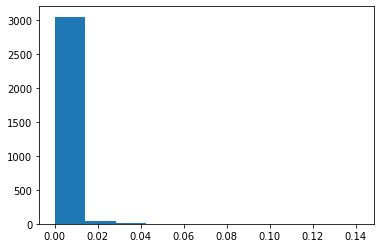

In [1246]:
plt.hist(master['case_per_pop'])

In [1247]:
master['case_per_pop'].describe()

count    3108.000000
mean        0.001994
std         0.004738
min         0.000000
25%         0.000333
50%         0.000784
75%         0.001943
max         0.141544
Name: case_per_pop, dtype: float64

In [1248]:
.95/2/2

0.2375

In [1249]:
master.shape[0] * 0.2375

738.15

In [1250]:
master.shape[0] - 739

2369

In [1251]:
master.shape[0] * .1

310.8

In [1252]:
above_std_1 = master.sort_values(by = 'case_per_pop', ascending = False).head(739)

In [1253]:
above_std_1['case_per_pop'] = ((above_std_1['case_per_pop'].values *0) +1).astype(int)

In [1254]:
below = master.sort_values(by = 'case_per_pop', ascending = False).tail(2369)

In [1255]:
below['case_per_pop'] = ((below['case_per_pop'].values *0)).astype(int)

In [1256]:
master['case_per_pop'] = pd.concat([above_std_1['case_per_pop'],below['case_per_pop']])
master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,estimate!!sex and age!!total population!!21 years and over ratio,estimate!!sex and age!!total population!!62 years and over ratio,estimate!!sex and age!!total population!!65 years and over ratio,estimate!!sex and age!!total population!!18 years and over.1 ratio,estimate!!sex and age!!total population!!18 years and over!!male ratio,estimate!!sex and age!!total population!!18 years and over!!female ratio,estimate!!sex and age!!total population!!18 years and over!!sex ratio (males per 100 females) ratio,estimate!!sex and age!!total population!!65 years and over.1 ratio,estimate!!sex and age!!total population!!65 years and over!!male ratio,estimate!!sex and age!!total population!!65 years and over!!female ratio
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.717645,0.170344,0.145833,0.757808,0.363297,0.394511,0.001668,0.145833,0.063188,0.082645
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.747221,0.239353,0.195404,0.780512,0.375307,0.405205,0.000445,0.195404,0.090675,0.104730
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.752230,0.219455,0.179738,0.789155,0.423668,0.365488,0.004495,0.179738,0.077729,0.102009
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.748613,0.191903,0.162516,0.793182,0.425179,0.368003,0.005127,0.162516,0.072491,0.090025
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.732622,0.215110,0.177518,0.766363,0.374621,0.391743,0.001658,0.177518,0.078758,0.098760


In [1257]:
master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,estimate!!sex and age!!total population!!21 years and over ratio,estimate!!sex and age!!total population!!62 years and over ratio,estimate!!sex and age!!total population!!65 years and over ratio,estimate!!sex and age!!total population!!18 years and over.1 ratio,estimate!!sex and age!!total population!!18 years and over!!male ratio,estimate!!sex and age!!total population!!18 years and over!!female ratio,estimate!!sex and age!!total population!!18 years and over!!sex ratio (males per 100 females) ratio,estimate!!sex and age!!total population!!65 years and over.1 ratio,estimate!!sex and age!!total population!!65 years and over!!male ratio,estimate!!sex and age!!total population!!65 years and over!!female ratio
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.717645,0.170344,0.145833,0.757808,0.363297,0.394511,0.001668,0.145833,0.063188,0.082645
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.747221,0.239353,0.195404,0.780512,0.375307,0.405205,0.000445,0.195404,0.090675,0.104730
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.752230,0.219455,0.179738,0.789155,0.423668,0.365488,0.004495,0.179738,0.077729,0.102009
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.748613,0.191903,0.162516,0.793182,0.425179,0.368003,0.005127,0.162516,0.072491,0.090025
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.732622,0.215110,0.177518,0.766363,0.374621,0.391743,0.001658,0.177518,0.078758,0.098760


In [1258]:
master['beds_per_pop'].value_counts()

0.000000    652
0.002416      2
0.005938      2
0.001425      2
0.002451      2
           ... 
0.011798      1
0.002766      1
0.006134      1
0.010653      1
0.016191      1
Name: beds_per_pop, Length: 2449, dtype: int64

In [1259]:
# master.to_csv('~/documents/case_per_pop_dummied_std_1.csv')

In [1260]:
master['case_per_pop'].value_counts(normalize = True)

0    0.762227
1    0.237773
Name: case_per_pop, dtype: float64

In [1261]:
master['case_per_pop'].value_counts(normalize = True)

0    0.762227
1    0.237773
Name: case_per_pop, dtype: float64

Since we are using accuracy as our metric, our baseline is a score of .76227, which would occur if our model predicted an area to not be a coronavirus hotspot.

In [1262]:
X = master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 'population', 
                           'case_per_pop', 'beds_per_case', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'population ratio'])
y = master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [1263]:
pipe = Pipeline([ #instantiate transformers and model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [1264]:
logreg_model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=di

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/pyt

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfg

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError:

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.8s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.9s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.9s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.9s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.9s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_w

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.7s finished


In [1265]:
logreg_train_score = logreg_model.score(X_train, y_train)

In [1266]:
logreg_test_score = logreg_model.score(X_test, y_test)

In [1267]:
logreg_model.best_params_

{'lr__class_weight': None,
 'lr__dual': False,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [1268]:
cross_val_score(logreg_model.best_estimator_, X_ss, y).mean()

0.7799374517814334

In [1269]:
coefs = logreg_model.best_estimator_.steps[0][1].coef_

In [1270]:
coef_df = pd.DataFrame(coefs).T

In [1271]:
coef_df['coefficients'] = list(X.columns)

In [1272]:
coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

In [1273]:
coef_df.sort_values(by = 'coefficient')

,coefficient,feature
898,-2.832380,estimate!!sex and age!!total population!!sex r...
74,-2.310513,estimate!!sex and age!!total population!!75 to...
892,-1.369009,"estimate!!citizen, voting age population!!citi..."
19,-0.870766,estimate!!race!!total population!!one race!!as...
877,-0.804109,estimate!!hispanic or latino and race!!total p...
...,...,...
843,0.820850,estimate!!race!!total population!!one race!!bl...
46,1.027792,estimate!!hispanic or latino and race!!total p...
18,1.275108,estimate!!race!!total population!!one race!!as...
75,1.423399,estimate!!sex and age!!total population!!85 ye...


In [1274]:
logreg_model.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=11,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [1275]:
logreg_train_score

0.8266838266838267

In [1276]:
logreg_test_score

0.8056628056628057

In [1277]:
coef_df['abs'] = abs(coef_df['coefficient'])

In [1278]:
lose_these = coef_df.loc[coef_df['abs'] < 0.0000001]

In [1279]:
# lose_these.to_csv('~/documents/bad_features.csv')

In [1280]:
list(lose_these['feature'].values)

['total_area',
 'estimate!!race!!total population!!one race',
 'estimate!!race!!total population!!two or more races',
 'estimate!!race!!total population!!one race.1',
 'estimate!!race!!total population!!one race!!white',
 'estimate!!race!!total population!!one race!!black or african american',
 'estimate!!race!!total population!!one race!!american indian and alaska native!!navajo tribal grouping',
 'estimate!!race!!total population!!one race!!asian',
 'estimate!!race!!total population!!one race!!asian!!chinese',
 'estimate!!race!!total population!!one race!!asian!!other asian',
 'estimate!!race!!total population!!one race!!native hawaiian and other pacific islander',
 'estimate!!race!!total population!!one race!!native hawaiian and other pacific islander!!native hawaiian',
 'estimate!!race!!total population!!one race!!some other race',
 'estimate!!race!!total population!!two or more races.1',
 'estimate!!race alone or in combination with one or more other races!!total population',
 'es

In [1281]:
better_master = master.drop(columns = list(lose_these['feature'].values))

In [1282]:
better_master.shape

(3108, 121)

In [1283]:
X = better_master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 'population', 
                           'case_per_pop', 'beds_per_case', 'unnamed: 0_y','st_num', 'cases',
                                  'countyfips', 'key_0', 'county', 'population ratio'])
y = better_master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [1284]:
pipe = Pipeline([ #instantiate transformers and model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1', 'l2', 'none'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [1285]:
logreg_2 = gs.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail


[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dic

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__du

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/pyt

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/e

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/pyt

[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test par

[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__pena

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_w

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_l

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=F

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [1286]:
logreg_2_train_score = logreg_2.score(X_train, y_train)

In [1287]:
logreg_2_test_score = logreg_2.score(X_test, y_test)

In [1288]:
logreg_2.best_params_

{'lr__class_weight': None,
 'lr__dual': True,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear'}

In [1289]:
cross_val_score(logreg_2.best_estimator_, X_ss, y).mean()

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

0.7815467221730328

In [1290]:
new_coefs = logreg_2.best_estimator_.steps[0][1].coef_

In [1291]:
new_coef_df = pd.DataFrame(new_coefs).T

In [1292]:
new_coef_df

,0
0,-0.026596
1,-0.036438
2,0.500673
3,-0.109867
4,0.152643
...,...
100,0.096917
101,0.315557
102,1.152635
103,-0.511083


In [1293]:
len(X.columns)

105

In [1294]:
new_coef_df['coefficients'] = list(X.columns)

In [1295]:
new_coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

In [1296]:
new_coef_df.sort_values(by = 'coefficient')

,coefficient,feature
23,-1.892139,estimate!!sex and age!!total population!!75 to...
84,-1.730283,estimate!!sex and age!!total population!!sex r...
82,-1.216620,"estimate!!citizen, voting age population!!citi..."
25,-0.946003,estimate!!sex and age!!total population!!media...
10,-0.910530,estimate!!race!!total population!!one race!!as...
...,...,...
50,0.826362,estimate!!race!!total population!!one race!!bl...
19,1.011351,estimate!!hispanic or latino and race!!total p...
24,1.035937,estimate!!sex and age!!total population!!85 ye...
102,1.152635,estimate!!sex and age!!total population!!18 ye...


In [1297]:
new_coef_df[abs(new_coef_df['coefficient']) > .0000001]

,coefficient,feature
0,-0.026596,land_area
1,-0.036438,water_area
2,0.500673,estimate!!race!!total population!!one race!!am...
3,-0.109867,estimate!!race!!total population!!one race!!am...
4,0.152643,estimate!!race!!total population!!one race!!am...
...,...,...
100,0.096917,estimate!!sex and age!!total population!!18 ye...
101,0.315557,estimate!!sex and age!!total population!!18 ye...
102,1.152635,estimate!!sex and age!!total population!!18 ye...
103,-0.511083,estimate!!sex and age!!total population!!65 ye...


In [1298]:
logreg_2.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=True,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=11,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [1299]:
print(f' Training Score: {logreg_2_train_score}')
print(f' Testing Score: {logreg_2_test_score}')



 Training Score: 0.8271128271128271
 Testing Score: 0.8018018018018018


# KNN Model

In [1300]:
pipe = Pipeline([
    ('knn', KNeighborsClassifier())])

# set hyperparameters

pipe_params = {
    'knn__n_neighbors': [3,5,7,9,27],
    'knn__weights' : ['uniform', 'distance'], # distance gives more predictive power to closer neighbors
    'knn__p': [1,2,'p'], # allows us to test Minkowski, Euclidean, and Manhattan measurements
               
              }

gsknn = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2
                    )

In [1301]:
knn_model = gsknn.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.2s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance ..........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance ...........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance .............
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance .............
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance .............
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance .............
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance .........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=7, knn__p=p, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=7, knn__p=p, knn__weights=distance .............
[CV]  knn__n_neighbors=7, knn__p=p, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=7, knn__p=p, knn__weights=distance .............
[CV]  knn__n_neighbors=7, knn__p=p, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ...........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance .............
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance .............
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance ...........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

In [1302]:
knn_model.score(X_test, y_test)

0.8082368082368082

In [1303]:
knn_model.score(X_train, y_train)

0.8365508365508365

In [1304]:
knn_model.best_params_

{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}

In [1305]:
cross_val_score(knn_model.best_estimator_, X_ss, y).mean()

0.7844323283160135

# SVM

In [1306]:
pipe = Pipeline([ #instantiate
    ('svc', SVC())])

# set hyperparameters

pipe_params = {
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__class_weight' : [dict, 'balanced'],
    'svc__random_state': [11],
    'svc__gamma' : ['scale', 'auto'],
    'svc__C' : [0, .5, 1],
    'svc__shrinking' : [True, False]
              }

gssvc = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [1307]:
svc_model = gssvc.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these

[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'd

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__s

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni


[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.9s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.2s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.7s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.9s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=sc

[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.9s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.5s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.2s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.3s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'd

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.3s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.1s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.5s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.4s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel

[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.6s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.4s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.8s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   3.7s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linea

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.0min finished


In [1308]:
svc_model.score(X_test, y_test)

0.8056628056628057

In [1309]:
svc_model.score(X_train, y_train)

0.8412698412698413

In [1310]:
svc_model.best_params_

{'svc__C': 1,
 'svc__class_weight': 'balanced',
 'svc__gamma': 'scale',
 'svc__kernel': 'poly',
 'svc__random_state': 11,
 'svc__shrinking': True}

In [1311]:
new_coef_df.sort_values(by = 'coefficient')

,coefficient,feature
23,-1.892139,estimate!!sex and age!!total population!!75 to...
84,-1.730283,estimate!!sex and age!!total population!!sex r...
82,-1.216620,"estimate!!citizen, voting age population!!citi..."
25,-0.946003,estimate!!sex and age!!total population!!media...
10,-0.910530,estimate!!race!!total population!!one race!!as...
...,...,...
50,0.826362,estimate!!race!!total population!!one race!!bl...
19,1.011351,estimate!!hispanic or latino and race!!total p...
24,1.035937,estimate!!sex and age!!total population!!85 ye...
102,1.152635,estimate!!sex and age!!total population!!18 ye...


In [1317]:
coef_df['actual_odds'] = np.exp(coef_df['coefficient'])

In [1318]:
new_coef_df['actual_odds'] = np.exp(new_coef_df['coefficient'])

In [1319]:
coef_df

,coefficient,feature,abs,actual_odds
0,0.000000,total_area,0.000000,1.000000
1,-0.007882,land_area,0.007882,0.992149
2,-0.014013,water_area,0.014013,0.986085
3,0.000000,estimate!!race!!total population!!one race,0.000000,1.000000
4,0.000000,estimate!!race!!total population!!two or more ...,0.000000,1.000000
...,...,...,...,...
921,0.199238,estimate!!sex and age!!total population!!18 ye...,0.199238,1.220473
922,2.130722,estimate!!sex and age!!total population!!18 ye...,2.130722,8.420946
923,0.000000,estimate!!sex and age!!total population!!65 ye...,0.000000,1.000000
924,-0.614837,estimate!!sex and age!!total population!!65 ye...,0.614837,0.540729


In [1320]:
new_coef_df

,coefficient,feature,actual_odds
0,-0.026596,land_area,0.973755
1,-0.036438,water_area,0.964218
2,0.500673,estimate!!race!!total population!!one race!!am...,1.649831
3,-0.109867,estimate!!race!!total population!!one race!!am...,0.895953
4,0.152643,estimate!!race!!total population!!one race!!am...,1.164909
...,...,...,...
100,0.096917,estimate!!sex and age!!total population!!18 ye...,1.101769
101,0.315557,estimate!!sex and age!!total population!!18 ye...,1.371022
102,1.152635,estimate!!sex and age!!total population!!18 ye...,3.166526
103,-0.511083,estimate!!sex and age!!total population!!65 ye...,0.599845


In [1325]:
lasso_eval = coef_df.loc[coef_df['coefficient'] != 0].sort_values(by = 'coefficient')

In [1326]:
#lasso_eval.to_csv('~/documents/lasso_coef.csv')

In [1327]:
logreg2_eval = new_coef_df.loc[new_coef_df['coefficient'] != 0].sort_values(by = 'coefficient')

In [1328]:
#logreg2_eval.to_csv('~/documents/logreg_coefs.csv')

In [1312]:
# master.to_csv('~/documents/master_w_ratios.csv')

In [1313]:
# better_master.to_csv('~/documents/lassoed_df.csv')

In [1314]:
new_coef_df.shape

(105, 2)

In [1315]:
# new_coef_df.to_csv('~/documents/top_55.csv')

# Decision Tree Classifier

In [1334]:
dt_pipe = Pipeline([
    ('dt' ,DecisionTreeClassifier())
])
pipe_params = {
    'dt__max_depth' : [10],
    'dt__min_samples_leaf' : [8],
    'dt__min_samples_split' : [3],
    }
gs = GridSearchCV(dt_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=StratifiedKFold(shuffle=True)
                  ,
                  verbose = 2) # 3-fold cross-validation.
gs.fit(X_train,y_train)
gs.best_params_
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Train Score 0.894036894036894
Test Score 0.7709137709137709
Cross Val Score 0.7532244952907611


# Bagging Classifier

In [1335]:
bag_pipe = Pipeline([
    ('bag', BaggingClassifier())])
pipe_params = {
    'bag__n_estimators': [50],
    'bag__max_features': [.9]
    }
gs = GridSearchCV(bag_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=StratifiedKFold(shuffle=True),
                  verbose = 2) # 3-fold cross-validation.
gs.fit(X_train,y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s finished


Train Score 0.9995709995709996
Test Score 0.8275418275418276
Cross Val Score 0.7995572953073303


# Random Forest Classifier

In [1337]:
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())])
rf_params = {
    'rf__max_depth':[5,10],
    'rf__n_estimators':[20,25,30]
}
gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv=5,verbose=50)
gs.fit(X_train, y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.799, total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.803, total=   0.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.790, total=   0.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.790, total=   0.2s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

# Adaboost

In [1340]:
ada_pipe = Pipeline([
    ('ada', AdaBoostClassifier())])
ada_params = {
    'ada__n_estimators' : [250],
    'ada__learning_rate' : [1.5]
    }
gs = GridSearchCV(ada_pipe, param_grid=ada_params, cv=StratifiedKFold(shuffle=True),verbose=12, n_jobs=-1)
gs.fit(X_train, y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.4s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


Train Score 0.9317889317889317
Test Score 0.752895752895753
Cross Val Score 0.7374647260149846
